In [273]:
import numpy as np # linear algebra

import seaborn as sns
sns.set_palette("husl")
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
PW = 10
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
#plt.rcParams['image.cmap'] = 'grey'

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

import datetime as dt
from scipy.stats import ttest_ind

dir_path = "./Meteorological Data/" 
%matplotlib inline

import os
print(os.listdir(dir_path))

['Sydney - 066062-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Melbourne - 086071-Table 1.csv', 'Adelaide - 023090-Table 1.csv', 'Brisbane - 040913-Table 1.csv']


In [274]:
files = ['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv',
         'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']

## Preprocessing

In [275]:
#Dict for renamimng columns
name_map= { u'Minimum temperature (°C)':"MinTemp",
                u'Maximum temperature (°C)': "MaxTemp",
                           u'Rainfall (mm)': "Rainfall",
                        u'Evaporation (mm)': "Evaporation",
                        u'Sunshine (hours)': "Sunshine",
         u'Direction of maximum wind gust ': "DirectOfMaxWind", 
       u'Speed of maximum wind gust (km/h)': "SpeedOfMaxWind",
               u'Time of maximum wind gust': "TimeOfMaxWind",
                    u'9am Temperature (°C)': "9am_Temp",
               u'9am relative humidity (%)': "9am_RelHumid",
                u'9am cloud amount (oktas)': "9am_Clouds",
                      u'9am wind direction': "9am_WindDirect",
                   u'9am wind speed (km/h)': "9am_WindSpeed",
                  u'9am MSL pressure (hPa)': "9am_Preassure",
                    u'3pm Temperature (°C)': "3pm_Temp",
               u'3pm relative humidity (%)': "3pm_RelHumid",
                u'3pm cloud amount (oktas)': "3pm_Clouds",
                      u'3pm wind direction': "3pm_WindDirect",
                   u'3pm wind speed (km/h)': "3pm_WindSpeed",
                  u'3pm MSL pressure (hPa)': "3am_Preassure",
                                 u'Quarter': u'Quarter',
                                  "TempVar":"TempVar"}

rev_name_map = {v: k for k, v in name_map.iteritems()}

In [292]:
city = 0
days = 365
df = pd.read_csv(dir_path + files[city], encoding="utf-8")
df["City"] = files[city].split(" ")[0]
df = df[-days:]

for city in range(1, len(files)):
    
    tdf = pd.read_csv(dir_path + files[city], encoding="utf-8")
    tdf = tdf[-days:]
    
    #Drop Unnamed Column
    if city in [1,2,4]:
        tdf.drop([tdf.columns[-1]], axis=1, inplace=True)
    
    tdf["City"] = files[city].split(" ")[0]
    df = pd.concat([df, tdf])
        
#Save Date for plotting
df["DateI"] = pd.to_datetime(df.Date)

df.set_index(pd.to_datetime(df.Date), inplace=True)

#Sort df
df = df.sort_values(["DateI","City"])

#Rename Columns
df.rename(index=str, columns=name_map, inplace=True)

#Add quartals of the year
df["Quarter"] = df.DateI.apply(lambda x: pd.Timestamp(x).quarter)
#Infere Season
df["Season"] = df["Quarter"].apply(lambda x: "Q2Q3" if x in[2,3] else "Q4Q1")

#New Columns
df["TempVar"] = df[u"MaxTemp"] - df[u"MinTemp"]

#Drop columns
df.drop(["Day","Date"], axis=1, inplace=True)

df.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,DirectOfMaxWind,SpeedOfMaxWind,TimeOfMaxWind,9am_Temp,9am_RelHumid,9am_Clouds,9am_WindDirect,9am_WindSpeed,9am_Preassure,3pm_Temp,3pm_RelHumid,3pm_Clouds,3pm_WindDirect,3pm_WindSpeed,3am_Preassure,City,DateI,Quarter,Season,TempVar
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,22.0,33.0,NaN,NaN,0.5,WSW,43.0,13:15,29.8,29.0,NaN,ENE,4.0,1006.1,29.7,50.0,NaN,SSW,24.0,1007.0,Adelaide,2014-01-01,1,Q4Q1,11.0
2014-01-01 00:00:00,20.6,30.6,0.0,3.4,12.5,ENE,31.0,14:18,28.8,52.0,4.0,SE,7.0,1015.2,28.9,52.0,1.0,ENE,11.0,1013.1,Brisbane,2014-01-01,1,Q4Q1,10.0
2014-01-01 00:00:00,16.2,26.3,0.0,10.6,0.0,N,80.0,11:01,21.9,91.0,NaN,N,43.0,1010.1,NaN,NaN,NaN,N,35.0,1003.7,Melbourne,2014-01-01,1,Q4Q1,10.1


##  Fill NaNs

In [293]:
#IsNan Cols#IsNan C 
p = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
p = p[p > 0]
p

3pm_Clouds         0.295342
9am_Clouds         0.276712
Evaporation        0.065753
Rainfall           0.050411
9am_WindSpeed      0.032877
Sunshine           0.006027
DirectOfMaxWind    0.006027
SpeedOfMaxWind     0.006027
TimeOfMaxWind      0.004384
3pm_WindSpeed      0.003288
3pm_RelHumid       0.002192
3pm_Temp           0.001644
9am_Temp           0.001096
9am_RelHumid       0.001096
TempVar            0.001096
9am_Preassure      0.000548
MaxTemp            0.000548
MinTemp            0.000548
dtype: float64

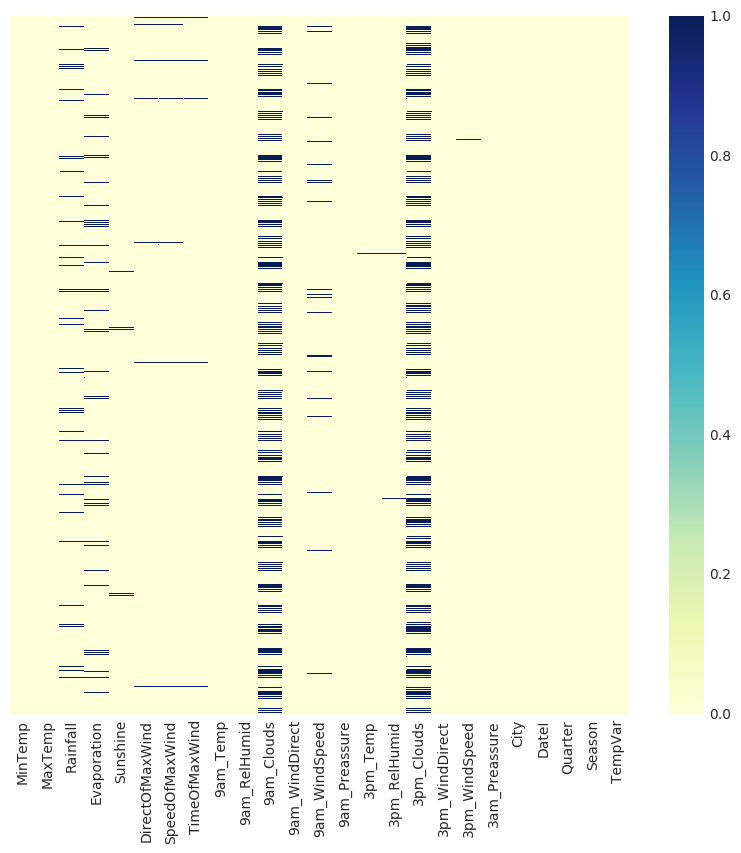

In [294]:
#Plot Nans
f, ax = plt.subplots(1,1,figsize=(PW,1.5*PH))

mnn = pd.DataFrame(np.array(df.isnull().values, dtype='bool')+1-1, columns=df.columns)
sns.heatmap(mnn, ax=ax, yticklabels=False, cmap="YlGnBu");

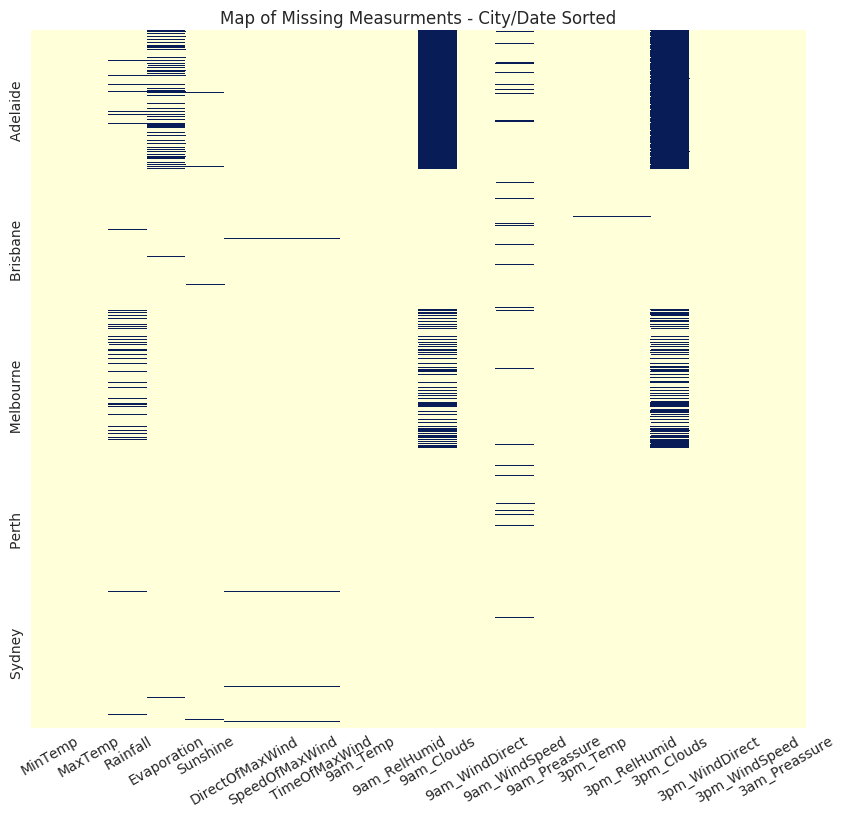

In [295]:
#Plot Nans Per City
f, ax = plt.subplots(1,1,figsize=(PW,1.5*PH))
cols = df.columns[0: len(df.columns) - 5]
topl = df.sort_values(["City","DateI"])[cols]

mnn = pd.DataFrame(np.array(topl.isnull().values, dtype='bool')+1-1, columns=topl.columns)
#Long Names
#mnn = mnn.rename(index=str, columns=rev_name_map)
sns_plt = sns.heatmap(mnn, ax=ax, yticklabels=False, cmap="YlGnBu", cbar=False);

ax.set_ylabel("                  ".join(['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney'][::-1]));
sns_plt.set_xticklabels(mnn.columns,rotation=30)

plt.title('Map of Missing Measurments - City/Date Sorted');
#sns_plt.figure.savefig("./Plots/" + "NaNs.png")

In [296]:
#Fill zeros for Adeleide
df.loc[df.City =="Adelaide", '9am_Clouds'] = 0
df.loc[df.City =="Adelaide", '3pm_Clouds'] = 0

#Fill Group Median/Mode
medCols = p.index
for col in medCols:
    if df[col].dtype != object:
        df[col] = df[col].fillna(df[col].median())
        df[col] = df.groupby(["City","Quarter"])[col].transform(lambda x: x.fillna(x.median()))
    else:
        df[col] = df.groupby(["City","Quarter"])[col].transform(lambda x: x.fillna(lambda y: y.mode()[0]))

## Exploratory Analysis

In [310]:
def plot_dists(df, p, order=None):  
    
    pal = sns.diverging_palette(200, 20, s=75, l=75, n=2)
    for col in p:
        if df[col].dtype == object or df[col].dtype == "datetime64[ns]":
            continue
        else:
            topl = df
            if len(topl) > 0:
                f, ax = plt.subplots(1, 1, figsize=(PW,PH))
                topl = df.rename(index=str, columns=rev_name_map)
                if order is not None:
                    topl["Sort"] = topl["City"].map(lambda x: order.loc[col,][x])
                    topl = topl.sort_values("Sort", ascending=True)
                    
                # ,split=True violinplot
                plt.title(rev_name_map[col] + " - Increasing Mean Ordered")
                sns_plt = sns.boxplot(x="City", y=rev_name_map[col], hue="Season", data=topl, palette=pal, ax=ax)
                plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [311]:
def roll(df, col, roll=10):
    ncol = col + "_MA"
    df[ncol] = df.groupby("City")[col].transform(lambda x: x.rolling(roll, min_periods=1).mean())
    df[ncol] = df[ncol].fillna(0)
    return ncol

def cumsumCat(df, col):
    ncol = col + "_CS"
    df[ncol] =  df.groupby(["City"])[col].transform(lambda x: x.cumsum())
    return ncol

def plot_time(topl, col, rev_name_map):
    f, ax = plt.subplots(1,1,figsize=(PW,PH)) 
    topl["Unit"] = 0
    #Rename
    topl = topl.rename(index=str, columns=rev_name_map)
    
    sns_plt = sns.tsplot(data=topl, time="DateI",condition="City", unit="Unit", value=col, ax=ax);

    xticks = ax.get_xticks();
    # convert all xtick labels to selected format from ms timestamp
    ax.set_xticklabels([pd.to_datetime(tm).date() for tm in xticks], rotation=50)

    xticks = ax.get_xticks();
    # convert all xtick labels to selected format from ms timestamp
    ax.set_xticklabels([pd.to_datetime(tm).date() for tm in xticks], rotation=50)

    ax.set_xlabel("Date")
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    return sns_plt

df.sort_values(["City","DateI"]);

def rank_stat(df, col):
    cities = df.groupby("City").sum().index.values
    rank = dict(zip(cities,np.zeros(len(cities))))
    for j in range(0,len(cities)):
        c1 = df[df.City==cities[j]]
        for i in range(j+1,len(cities)):
            c2 = df[df.City==cities[i]]
            rank[cities[j]] += ttest_ind(c1[col],c2[col], equal_var=False)[0] > 0 #Welch's
            rank[cities[i]] += ttest_ind(c1[col],c2[col], equal_var=False)[0] <= 0
    return rank

def calc_stat(df, cols):
    stats = []
    for col in cols:
        if df[col].dtype == object or df[col].dtype == "datetime64[ns]":
                continue
        rank = rank_stat(df, col)
        rank["Type"] = col
        stats.append(rank)
    stdf = pd.DataFrame(stats).set_index("Type")

    return stdf

def plot_corr(df, cols):
    #Calculate correlations
    topl = df[cols].rename(index=str, columns=rev_name_map)

    corr = topl.corr()
 
    # Heatmap
    f, ax = plt.subplots(1,1,figsize=(PW,PH)) 
    sns_plt = sns.heatmap(corr, vmin=0, square=True, cmap="YlGnBu", ax=ax);
    sns_plt.set_xticklabels(topl.columns,rotation=30)
    sns_plt.set_yticklabels(topl.columns,rotation=30);
    plt.title("Perason Correlation's of Temp. Measurements")

## Temperature

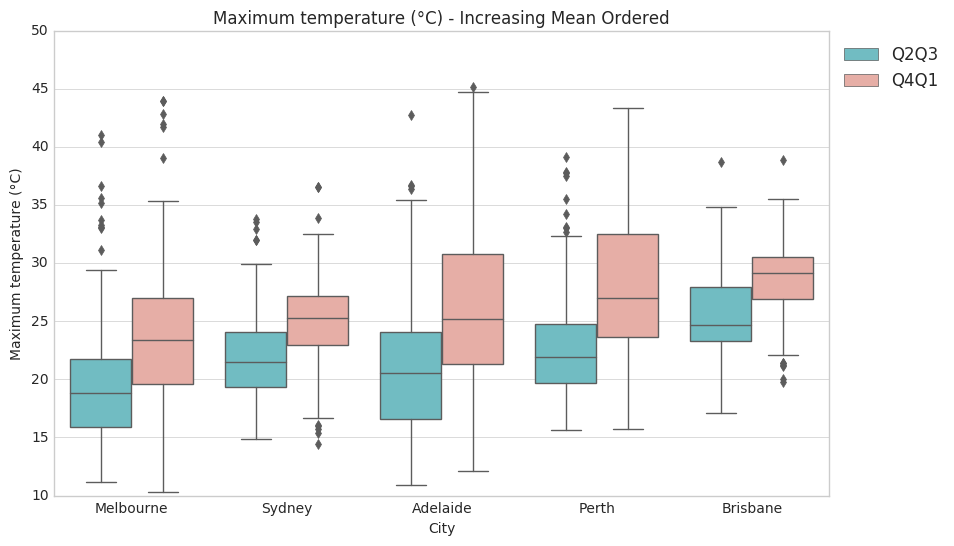

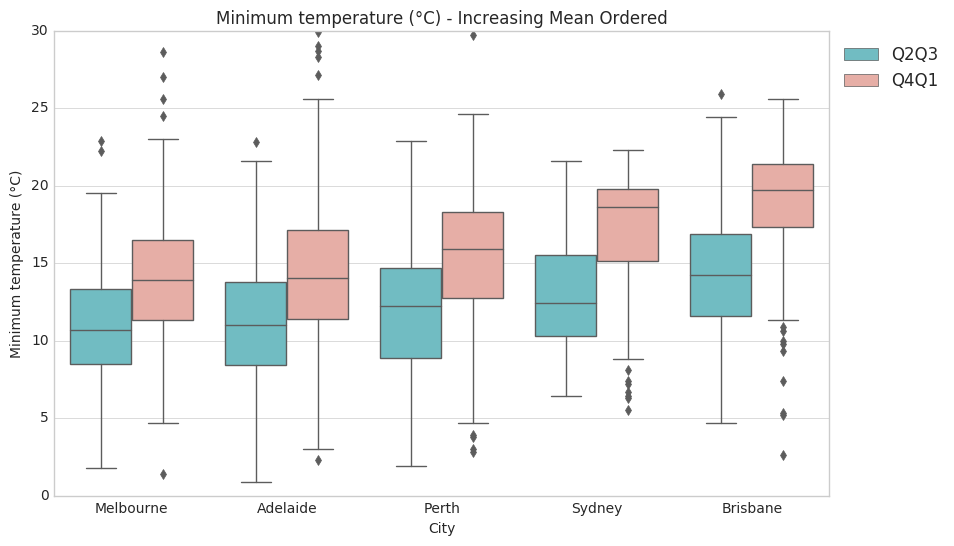

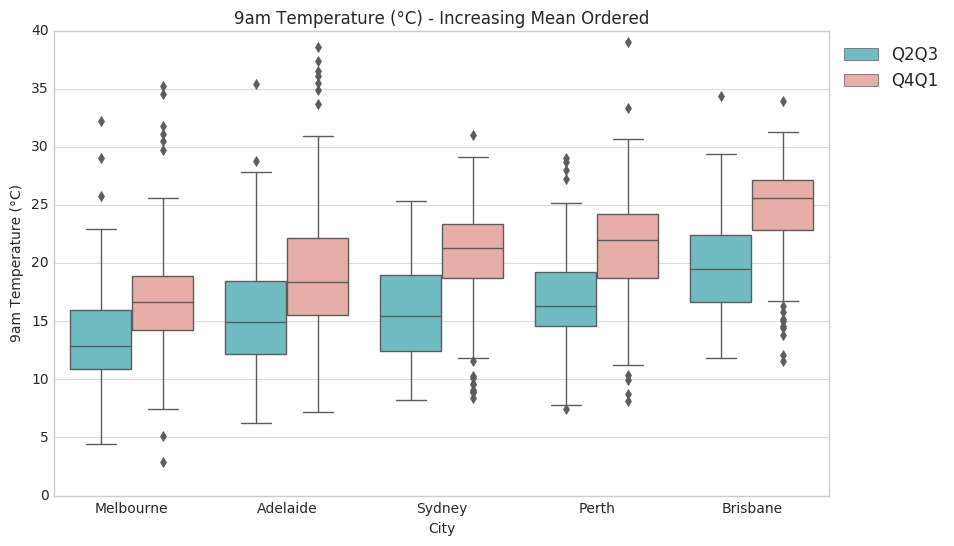

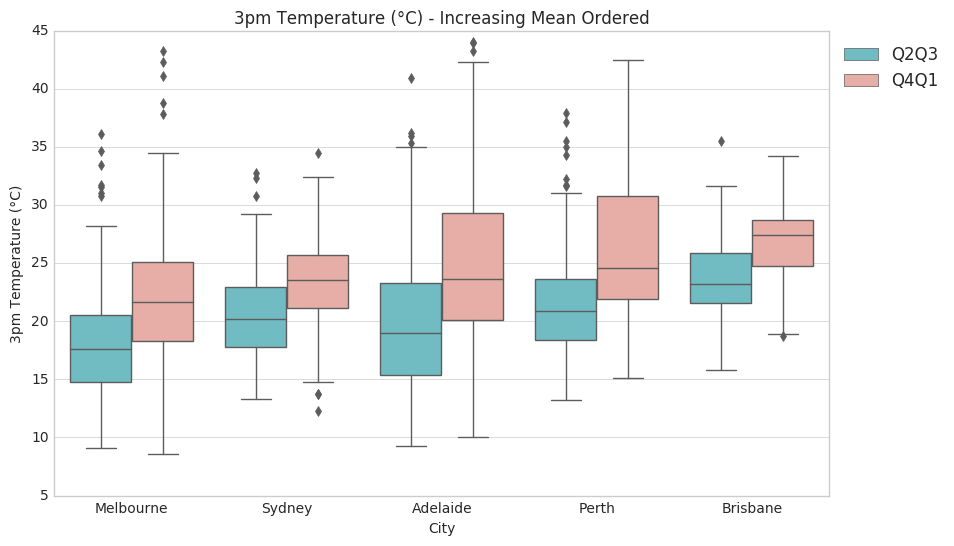

In [312]:
cols = ["MaxTemp","MinTemp","9am_Temp","3pm_Temp"]
order = calc_stat(df, cols)

plot_dists(df, cols, order)

In [323]:
calc_stat(df, cols), calc_stat(df[df.Season == "Q4Q1"], cols), calc_stat(df[df.Season == "Q2Q3"], cols)

(          Adelaide  Brisbane  Melbourne  Perth  Sydney
 Type                                                  
 MaxTemp        2.0       4.0        0.0    3.0     1.0
 MinTemp        1.0       4.0        0.0    2.0     3.0
 9am_Temp       1.0       4.0        0.0    3.0     2.0
 3pm_Temp       2.0       4.0        0.0    3.0     1.0,
           Adelaide  Brisbane  Melbourne  Perth  Sydney
 Type                                                  
 MaxTemp        2.0       4.0        0.0    3.0     1.0
 MinTemp        1.0       4.0        0.0    2.0     3.0
 9am_Temp       1.0       4.0        0.0    3.0     2.0
 3pm_Temp       2.0       4.0        0.0    3.0     1.0,
           Adelaide  Brisbane  Melbourne  Perth  Sydney
 Type                                                  
 MaxTemp        1.0       4.0        0.0    3.0     2.0
 MinTemp        1.0       4.0        0.0    2.0     3.0
 9am_Temp       1.0       4.0        0.0    3.0     2.0
 3pm_Temp       1.0       4.0        0.0    3.

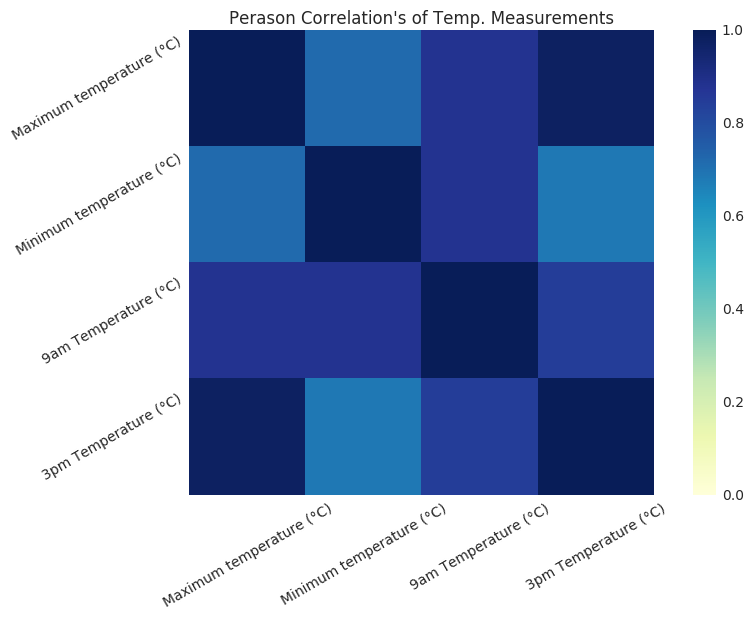

In [309]:
plot_corr(df, cols)

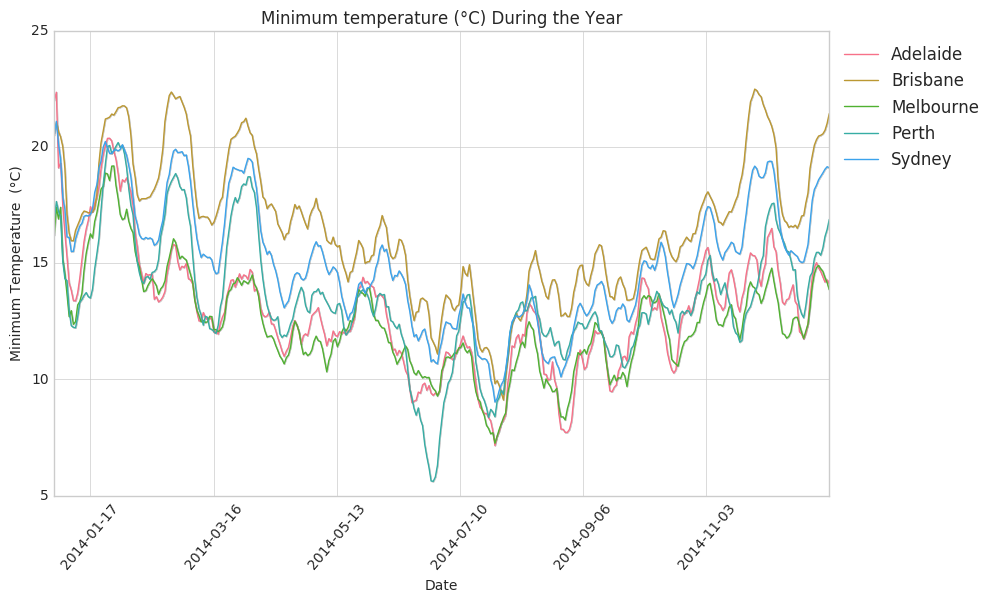

In [322]:
col = "MinTemp"
ncol = roll(df, col, 15)

#Residual
#df[ncol] = df[col] - df[ncol]

sns_plt = plot_time(df, ncol, rev_name_map);
sns_plt.set_ylabel(u"Maximaum Temperature (°C)");
sns_plt.set_ylabel(u"Minimum Temperature  (°C)");
plt.title(u"Minimum temperature (°C) During the Year");
#sns_plt.figure.savefig("./Plots/" + "RainfallWInter.png")

## Rainfall

In [ ]:
##Percantage of days without rain
df["HasRain"] = df["Rainfall"].apply(lambda x: 1.0 if x > 0 else 0.0) 
topl = df.groupby("City",as_index=False).sum()[["HasRain","City"]] 
#topl["HasRain"] /= days
topl["Total"]  = 1.0 * days
topl = topl.sort_values("HasRain")

sns.set_color_codes("pastel")
sns_plt = sns.barplot(x="Total", y="City", data=topl, label="Total", color="b")
sns.set_color_codes("muted")
sns_plt = sns.barplot(x="HasRain", y="City", data=topl, label="Total", color="b");

sns_plt.set_xlabel("Days")
sns_plt.set_xlim(0,days)
plt.title('Number of Days with Rainfall');

In [ ]:
# col = "Rainfall"
# ncol = roll(df, col, 10)

# #Residual
# #df[ncol] = df[col] - df[ncol]

# topl = df.rename(index=str, columns=rev_name_map)
# plot_time(topl, ncol)
# sns_plt.figure.savefig("./Plots/" + "RainfallWInter.png")

In [ ]:
col = "Rainfall"
ncol = cumsumCat(df, col)

topl = df.rename(index=str, columns=rev_name_map)
sns_plt = plot_time(df, ncol)

sns_plt.set_ylabel("Cumulative Rainfall")

sns_plt.figure.savefig("./Plots/" + "CumulativeRainFall.png")

## Sunny Days/Clouds

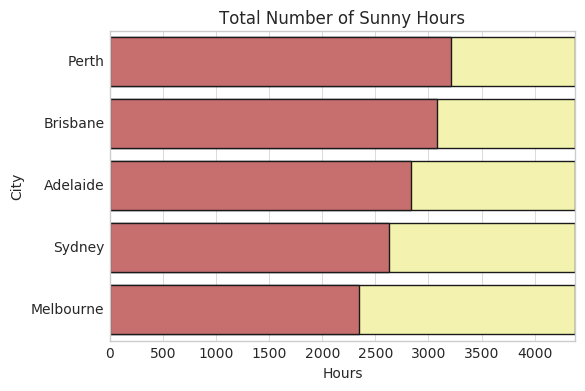

In [315]:
##Sunshine Hours
topl = df.groupby("City",as_index=False).sum()[["Sunshine","City"]] 
#topl["HasRain"] /= days
topl["Total"]  = 12 * days
topl = topl.sort_values("Sunshine", ascending=False)

sns.set_color_codes("pastel")
sns_plt = sns.barplot(x="Total", y="City", data=topl, label="Total", color="y")

sns.set_color_codes("muted")
sns_plt = sns.barplot(x="Sunshine", y="City", data=topl, label="Total", color="r");

sns_plt.set_xlabel("Hours")
sns_plt.set_xlim(0,12 * days)
plt.title('Total Number of Sunny Hours');


## Evaporation/Humidity

## ARIMA Modeling

In [96]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

In [97]:
def test_stat(series):
    dftest = adfuller(series)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

Test Statistic                -9.505205e+00
p-value                        3.361719e-16
Lags Used                      4.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (5%)           -2.869602e+00
Critical Value (1%)           -3.448646e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


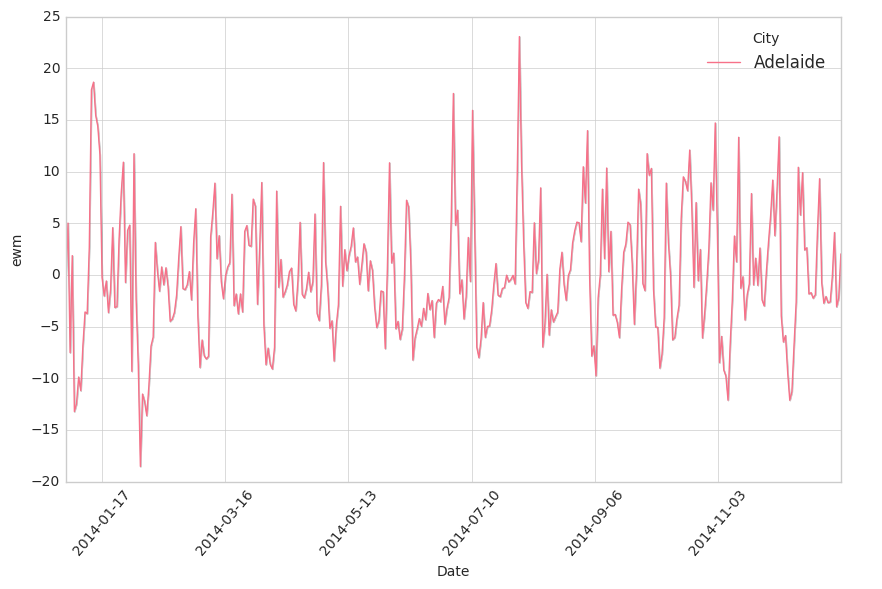

In [98]:
col= u'MaxTemp'
city =  "Adelaide"

totst = df[df.City == city].copy()

ncol = "ewm"
totst[ncol] = pd.DataFrame.ewm(totst[col].to_frame(), halflife=10).mean()

totst[ncol] = totst[col] - totst[ncol]

sns_plt = plot_time(totst, ncol);
sns_plt.figure.savefig("./Plots/" + "MinTemp.png")

test_stat(totst[ncol])

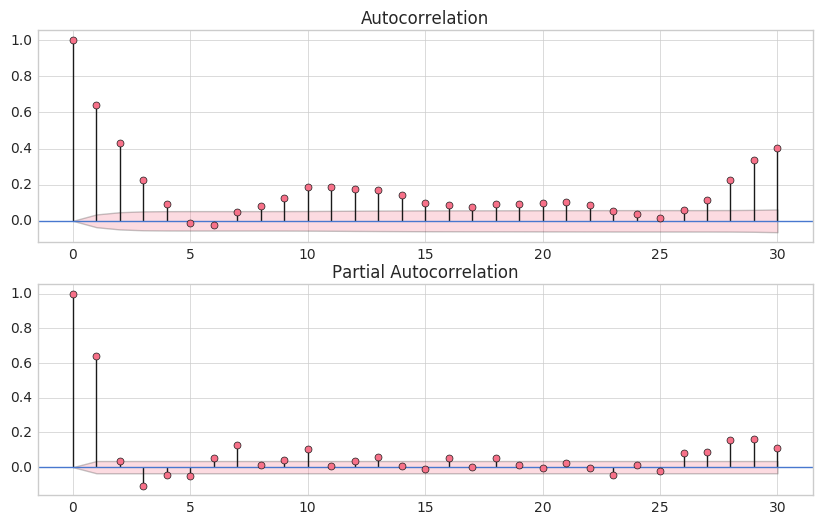

In [99]:
#Test
series = totst[col]

lags = 30
f, ax = plt.subplots(2,1,figsize=(PW,PH)) 
smt.graphics.plot_acf(series, lags=lags, ax=ax[0], alpha=0.5);
smt.graphics.plot_pacf(series, lags=lags, ax=ax[1], alpha=0.5);

In [100]:
# col = u'Maximum temperature (°C)'
# window = 5
# ncol = roll(df, col, window)

# #Residual
# #df[ncol] = df[col] - df[ncol]

# topl = df#[df.Season == "Winter"]
# plot_time(topl, ncol)
# sns_plt.figure.savefig("./Plots/" + "MaxTemp.png")

In [101]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
#alpha
dl.params[0]

ValueError: Given a pandas object and the index does not contain dates

In [ ]:
mdl = ARMA(series,order=(0,1,2)).fit(maxlag=30, ic='aic', trend='nc')
mdl.params[0]